 <h1>Brain Tumor Detection via CNN ML Networks</h1>

<h2>NOTICE: Run these commands if using AWS Sagemaker (STILL A WORK IN PROGRESS)</h2>
<p>Ensure that GPU optimization for TF works properly</p>
<ul>
    <li>cat /sys/bus/pci/devices/0000:00:1e.0/numa_node</li>
    <li>If not -1:</li>
    <li>sudo echo 0 | sudo tee -a /sys/bus/pci/devices/0000:00:1e.0/numa_node</li>
</ul>

In [1]:
# Added this for myself mainly for AWS adjust as needed
!pip install seaborn
!pip install pyyaml h5py
#sudo apt-get install pciutils
#sudo echo 0 | sudo tee -a /numa_node

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


Add and import neccesary libraries

In [2]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Loading the datasets (they are already split into Training and Testing datasets). The dataset is cited below but was downloaded off of Kaggle.com

In [4]:
# Set the path to the dataset
# Define the training and testing directories
# adjust filepaths as needed
train_dir = "/home/sagemaker-user/BrainTumorDetectionML/Data/Training"
test_dir = "/home/sagemaker-user/BrainTumorDetectionML/Data/Testing"

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

<h3>Data Preprocessing</h3>

In [7]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * 
                                    count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)


<h2>Data Visualization with Bar Graph</h2>

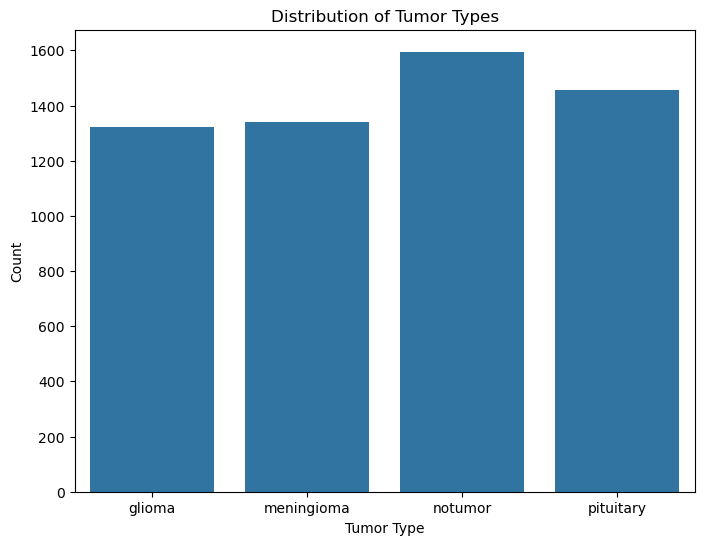

In [8]:
# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.savefig("/home/sagemaker-user/BrainTumorDetectionML/plots/dataDistribution.png")
plt.show()

<h2>Actual Example Images of each type of Tumor</h2>

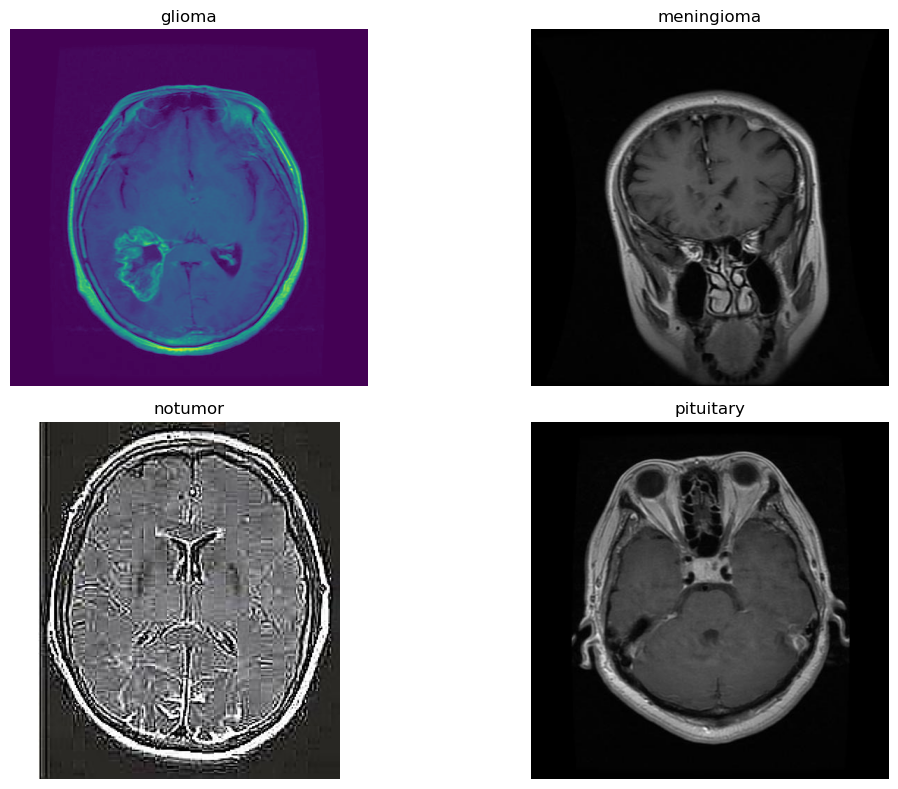

In [9]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.savefig("/home/sagemaker-user/BrainTumorDetectionML/plots/exampleTumors.png")
plt.show()

<h3>Image Preprocessing</h3>

Sets up size of the images as well as the total batch size for each epoch.

In [10]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

<h2>Data Augmentation/Preprocessing Continued</h2>

In [11]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [12]:
# Define the model architecture

with tf.device('/device:CPU:0'):
    model = keras.Sequential()
    model.add(keras.Input(shape=(image_size[0], image_size[1], 3, )))
    model.add(keras.layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(len(categories), activation="softmax"))
    
    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/50
178/178 [==============================] - 73s 404ms/step - loss: 0.9548 - accuracy: 0.5852 - val_loss: 0.8250 - val_accuracy: 0.6617
Epoch 2/50
178/178 [==============================] - 66s 368ms/step - loss: 0.7406 - accuracy: 0.7037 - val_loss: 0.8890 - val_accuracy: 0.6469
Epoch 3/50
178/178 [==============================] - 65s 366ms/step - loss: 0.6250 - accuracy: 0.7511 - val_loss: 0.7772 - val_accuracy: 0.6906
Epoch 4/50
178/178 [==============================] - 66s 371ms/step - loss: 0.5365 - accuracy: 0.7981 - val_loss: 0.6634 - val_accuracy: 0.7352
Epoch 5/50
178/178 [==============================] - 68s 380ms/step - loss: 0.4775 - accuracy: 0.8194 - val_loss: 1.0267 - val_accuracy: 0.6445
Epoch 6/50
178/178 [==============================] - 65s 367ms/step - loss: 0.4270 - accuracy: 0.8400 - val_loss: 0.5701 - val_accuracy: 0.7844
Epoch 7/50
178/178 [==============================] - 66s 368ms/step - loss: 0.3803 - accuracy: 0.8586 - val_loss: 0.6267 - val_ac

Save Model for later

<h2>Precision & Accuracy Measurements</h2>

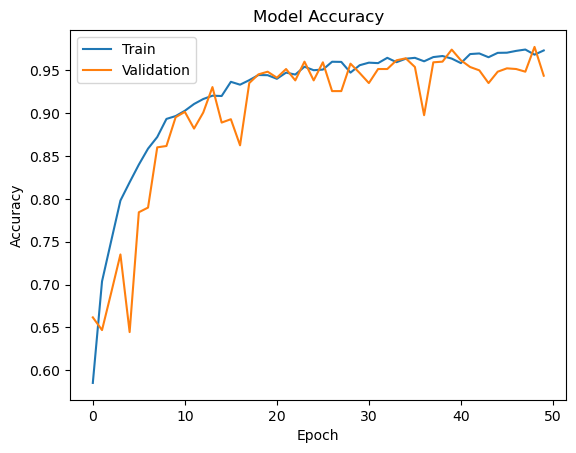

In [14]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.savefig('/home/sagemaker-user/BrainTumorDetectionML/plots/Model_Accuracy.png')
plt.show()

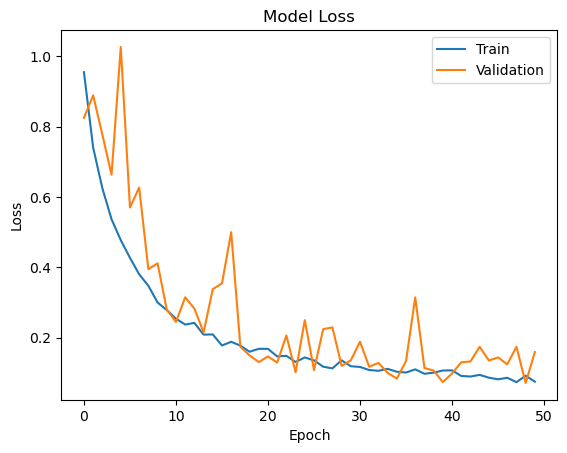

In [15]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.savefig('/home/sagemaker-user/BrainTumorDetectionML/plots/Model_Loss.png')
plt.show()

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 4s 96ms/step - loss: 0.1589 - accuracy: 0.9438
Test Loss: 0.15892952680587769
Test Accuracy: 0.9437500238418579


41/41 [==============================] - 4s 96ms/step


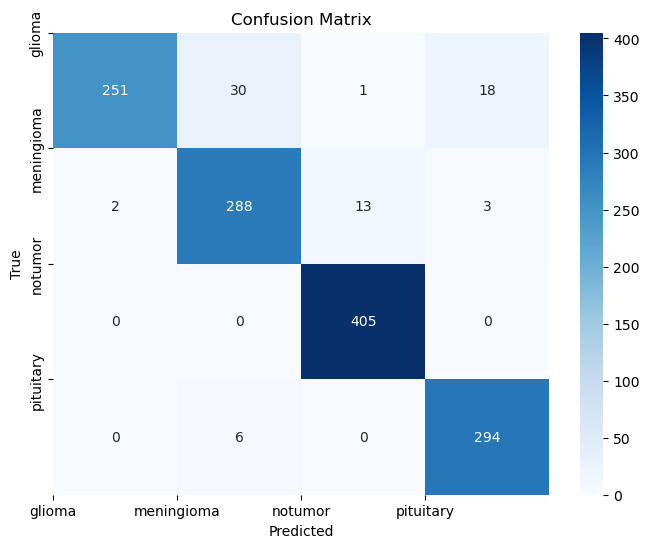

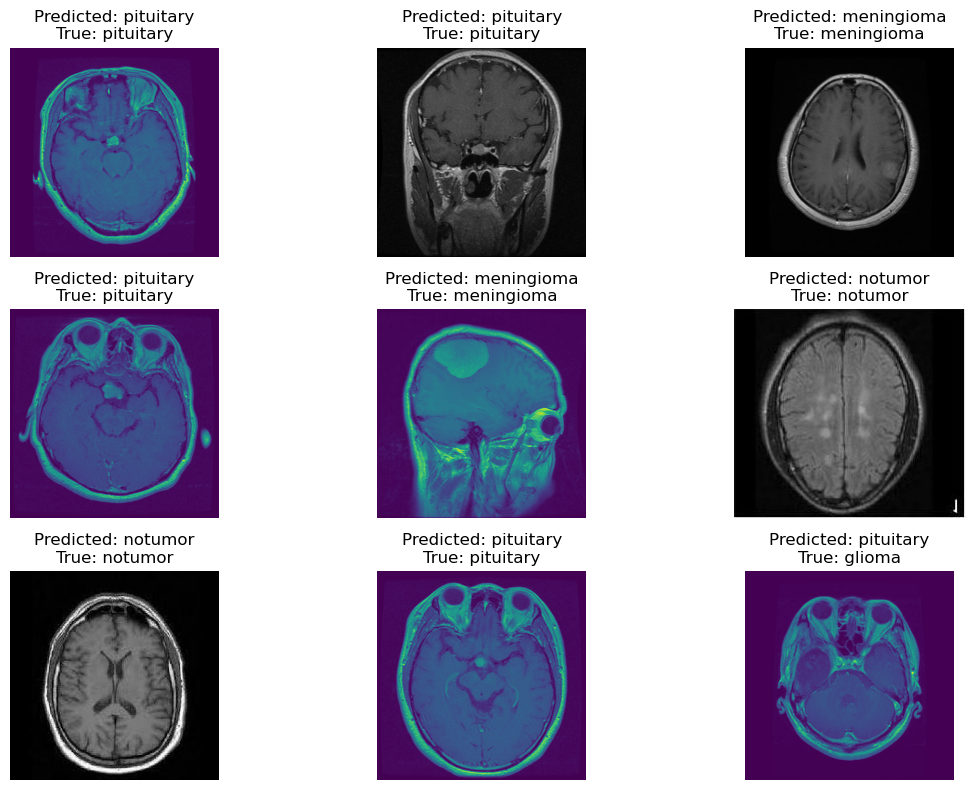

In [17]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9920948616600791
Recall: 0.8366666666666667
F1-Score: 0.9077757685352622

Class: meningioma
Precision: 0.8888888888888888
Recall: 0.9411764705882353
F1-Score: 0.9142857142857143

Class: notumor
Precision: 0.9665871121718377
Recall: 1.0
F1-Score: 0.9830097087378641

Class: pituitary
Precision: 0.9333333333333333
Recall: 0.98
F1-Score: 0.9560975609756097



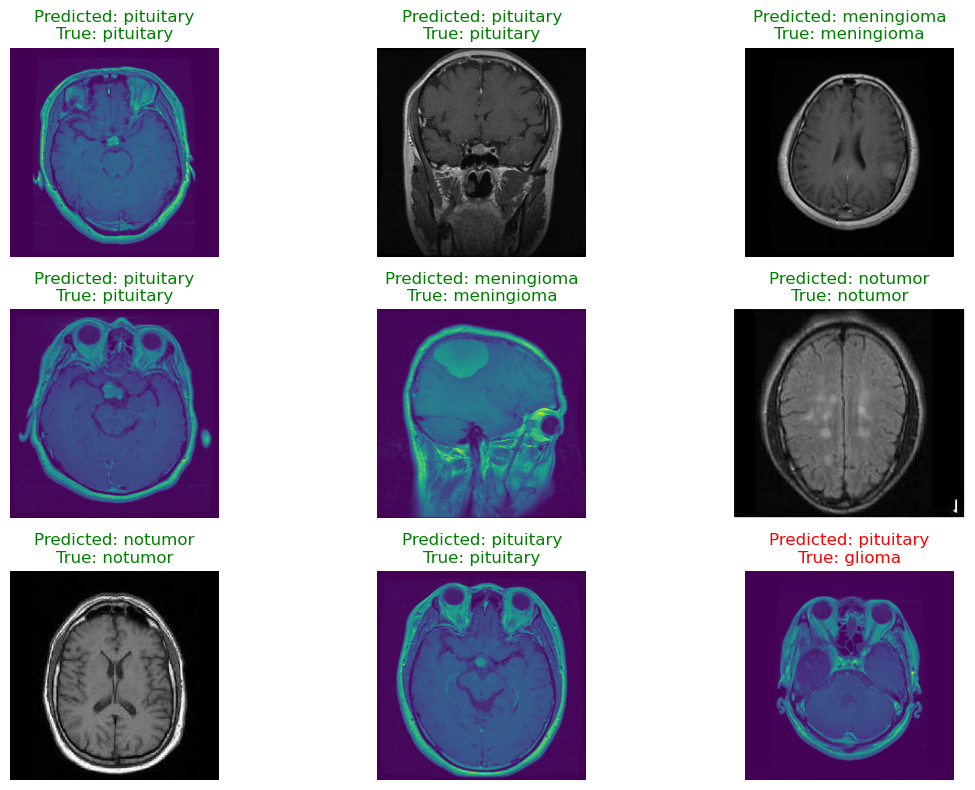

In [18]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [19]:
model.save("/home/sagemaker-user/BrainTumorDetectionML/savedModels/tumorML.h5")
model.save("/home/sagemaker-user/BrainTumorDetectionML/savedModels/tumorML.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
history = tf.keras.models.load_model('/home/sagemaker-user/BrainTumorDetectionML/savedModels/tumorML.keras')

41/41 [==============================] - 4s 94ms/step


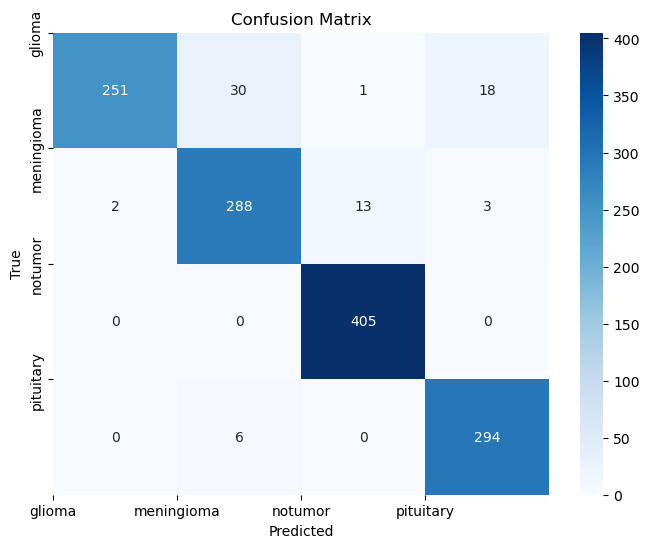

In [21]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.savefig("/home/sagemaker-user/BrainTumorDetectionML/plots/confusionMatrix.png")
plt.show()

Class: glioma
Precision: 0.9920948616600791
Recall: 0.8366666666666667
F1-Score: 0.9077757685352622

Class: meningioma
Precision: 0.8888888888888888
Recall: 0.9411764705882353
F1-Score: 0.9142857142857143

Class: notumor
Precision: 0.9665871121718377
Recall: 1.0
F1-Score: 0.9830097087378641

Class: pituitary
Precision: 0.9333333333333333
Recall: 0.98
F1-Score: 0.9560975609756097



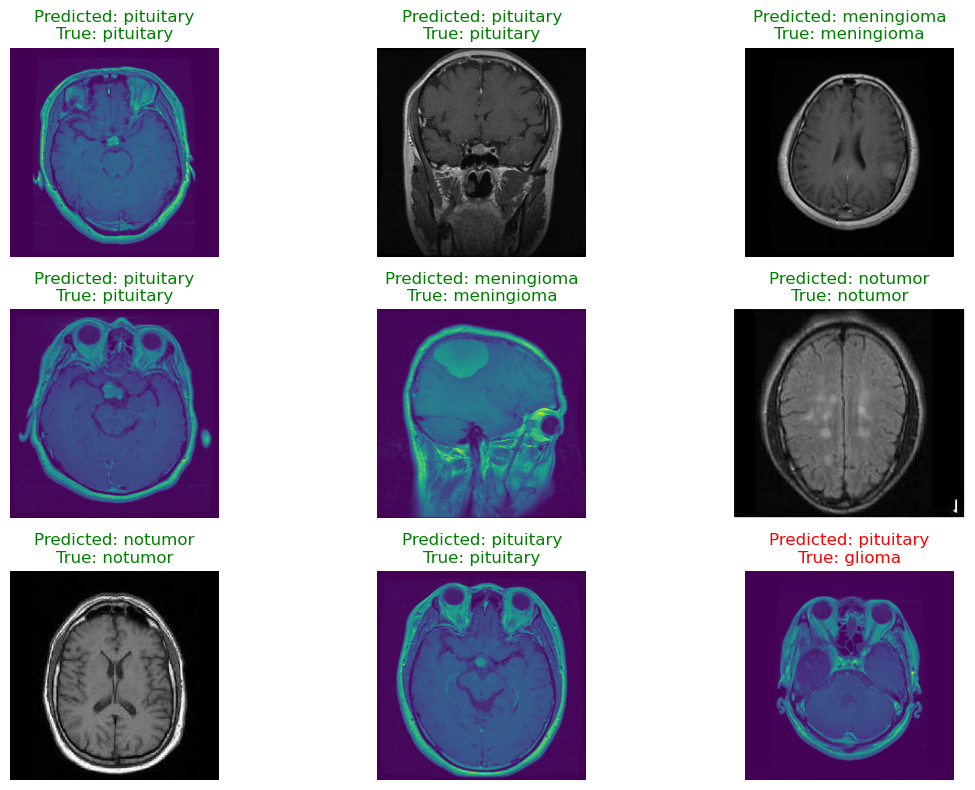

In [22]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.savefig("/home/sagemaker-user/BrainTumorDetectionML/plots/modelPredictions.png")
plt.show()